In [ ]:
!kill -9 -1

In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten,MaxPooling2D,Activation,Conv2D
from keras.layers import Dropout,BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import tensorflow as tf
from keras.models import load_model
import dlib
from keras.utils import np_utils

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [4]:
os.chdir('/content/gdrive/MyDrive/')

In [5]:
data = pd.read_csv('fer2013.csv')

In [ ]:
data.shape

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


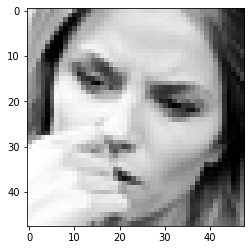

In [ ]:
a=data.loc[2,"pixels"]

a=[int(s) for s in a.split(' ')]

array = np.array(a, dtype=np.uint8)

array=array.reshape(48,48)

plt.imshow(cv2.cvtColor(array, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
data.loc[:,"emotion"].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
data.groupby('Usage')["pixels"].nunique()

Usage
PrivateTest     3572
PublicTest      3563
Training       27473
Name: pixels, dtype: int64

In [6]:
Xtrain,ytrain,Xtest,ytest=[],[],[],[]

In [ ]:
#Xtrain=data[data.loc[:,"Usage"]=="Training"].loc[:,"pixels"]
#Xtrain=Xtrain.apply(lambda a:[int(s) for s in a.split(' ')])
#taking forever to run

In [7]:
for i,rows in data.iterrows():
    pixvals=rows["pixels"].split()
    if rows["Usage"]=="Training":
        Xtrain.append(np.array(pixvals,'float32'))
        ytrain.append(rows['emotion'])
    else:
        Xtest.append(np.array(pixvals,'float32'))
        ytest.append(rows['emotion'])

In [8]:
Xtrain=np.array(Xtrain,'float32')
Xtest=np.array(Xtest,'float32')
ytrain=np.array(ytrain,'float32')
ytest=np.array(ytest,'float32')

In [9]:
x_mean=np.mean(Xtrain,axis=0)
x_sd=np.std(Xtrain,axis=0)

In [10]:
Xtrain=(Xtrain-x_mean)/x_sd
Xtest=(Xtest-x_mean)/x_sd

In [11]:
height=width=48
Xtrain=Xtrain.reshape(Xtrain.shape[0],width,height,1)
Xtest=Xtest.reshape(Xtest.shape[0],width,height,1)

In [12]:
#CNN
batch_size=64
epochs=50
labels=7
filters=64

In [13]:
ytrain=np_utils.to_categorical(ytrain,num_classes=labels)
ytest=np_utils.to_categorical(ytest,num_classes=labels)


In [ ]:
#Sequential
model=Sequential()
model.add(Conv2D(filters,(3,3),input_shape=(Xtrain.shape[1:]),activation='relu',kernel_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(Conv2D(filters,(3,3),activation='relu',kernel_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters,(3,3),activation='relu',kernel_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(Conv2D(filters,(3,3),activation='relu',kernel_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*filters,(3,3),activation='relu',kernel_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(Conv2D(2*filters,(3,3),activation='relu',kernel_regularizer=l2(0.0003)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16*filters,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16*filters,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(labels,activation='softmax'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=6,restore_best_weights=True)


model.compile(loss=categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])

model.fit(Xtrain,ytrain,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(Xtest,ytest),shuffle=True,callbacks=[es])



In [ ]:
seqpred=model.predict(Xtest)

In [ ]:
tf.math.confusion_matrix(np.argmax(ytest,1),np.argmax(seqpred,1))

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 517,    6,   48,   48,  179,   10,  150],
       [  44,   34,   12,    3,   11,    3,    4],
       [ 184,    2,  238,   56,  273,   97,  174],
       [  74,    0,   25, 1452,   69,   37,  117],
       [ 130,    1,   61,   61,  671,   18,  305],
       [  45,    0,   79,   57,   15,  577,   58],
       [  66,    2,   30,   68,  215,   16,  836]], dtype=int32)>

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping,ModelCheckpoint
import string

In [ ]:
act=tf.nn.leaky_relu
pool=(3,3)
pad="valid"
pad2="same"

In [ ]:
img_inputs=keras.Input(shape=Xtrain.shape[1:])

In [ ]:
def inception_layer(layer,f1,f2,f3,act,pool,pad):
    conv1=layers.Conv2D(f1,1,padding=pad,activation=act)(layer)
    conv2=layers.Conv2D(f2,3,padding=pad,activation=act)(layer)
    conv3=layers.Conv2D(f3,5,padding=pad,activation=act)(layer)
    max_pool=layers.MaxPooling2D(pool, strides=(1,1), padding=pad)(layer)
    out=layers.concatenate([conv1,conv2,conv3,max_pool],axis=-1)
    return out

In [ ]:
def residual_layer(layer,f,act,pad):
    conv1=layers.Conv2D(f,3,padding=pad,activation=act)(layer)
    conv2=layers.Conv2D(f,3,padding=pad,activation=act)(conv1)
    out=layers.add([conv2,layer])
    out=layers.Activation(act)(out)
    return out
    

In [ ]:
#functional-api_model
x=inception_layer(img_inputs,64,128,32,act,pool,pad2)
x=layers.Conv2D(filters,pool,activation=act,kernel_regularizer=l2(0.0003))(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D(pool_size=pool,strides=(2,2))(x)
x=layers.Dropout(0.5)(x)
x=residual_layer(x,filters,act,pad2)
x=layers.Conv2D(filters*2,pool,activation=act,kernel_regularizer=l2(0.0003))(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D(pool_size=pool,strides=(2,2))(x)
x=layers.Dropout(0.5)(x)
x=residual_layer(x,filters*2,act,pad2)
x=layers.Flatten()(x)
x=layers.Dense(16*filters,activation=act)(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(16*filters,activation=act)(x)
x=layers.Dropout(0.2)(x)
output=layers.Dense(labels,activation='softmax')(x)




In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=8,restore_best_weights=True)
mc = ModelCheckpoint("just.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#model.summary()
model=keras.Model(img_inputs,output,name="f_model")
model.save_weights("weights.h5")

In [ ]:
d={}
for i in range(10):
  #d["model{0}".format(i)]=keras.Model(img_inputs,output,name="f_model")
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=8,restore_best_weights=True)
  name="model"+str(i)+'.h5'
  mc = ModelCheckpoint(name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#f_model.summary()
  globals()["model"+str(i)]=keras.Model(img_inputs,output,name="f_model")
  globals()["model"+str(i)].compile(loss=categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])

  globals()["model"+str(i)].load_weights("weights.h5")
  globals()["model"+str(i)].fit(Xtrain,ytrain,batch_size=batch_size,epochs=21,verbose=1,validation_data=(Xtest,ytest),shuffle=True,callbacks=[es,mc])

In [ ]:
for i in range(10):
  name="model"+str(i)+".h5"
  avef_model=load_model(name,custom_objects={'leaky_relu':tf.nn.leaky_relu})
  pred=avef_model.predict(Xtest)
  print(name,'\n')
  print(tf.math.confusion_matrix(np.argmax(ytest,1),np.argmax(pred,1)))
  #0,1,5,6,7,9,4


model2.h5 

tf.Tensor(
[[ 407    3  155   56  155   17  165]
 [  29   41    7    5   19    2    8]
 [  82    2  413   56  200  102  169]
 [  22    0   64 1459   74   40  115]
 [  86    0  158   86  597   17  303]
 [  16    0   78   40   18  615   64]
 [  45    0   52  108  175   21  832]], shape=(7, 7), dtype=int32)
model3.h5 

tf.Tensor(
[[ 366    8  120   36  186   40  202]
 [  16   46   17    4   16    3    9]
 [  50    5  373   34  237  165  160]
 [  37    0   35 1368   92   58  184]
 [  58    3  124   40  658   34  330]
 [  20    0   31   41   33  654   52]
 [  27    1   66   38  201   51  849]], shape=(7, 7), dtype=int32)
model8.h5 

tf.Tensor(
[[ 500   12   62  101  107   27  149]
 [  33   57    4    7    4    1    5]
 [ 148   12  346   99  168   97  154]
 [  39    1   25 1527   43   37  102]
 [ 185    7  139  133  502    9  272]
 [  35    2   63   55   18  617   41]
 [  99    5   57  132  135   12  793]], shape=(7, 7), dtype=int32)


In [ ]:
#transfer learning performed poorly
from tensorflow.keras.applications.densenet import DenseNet201
height=width=48
Xtrain=Xtrain.reshape(Xtrain.shape[0],width,height)
Xtest=Xtest.reshape(Xtest.shape[0],width,height)
xtrain_rgb = np.repeat(Xtrain[..., np.newaxis], 3, -1)
xtest_rgb=np.repeat(Xtest[..., np.newaxis], 3, -1)
pretrained_model=DenseNet201(input_shape=xtrain_rgb.shape[1:],include_top=False,weights='imagenet',pooling='avg',classes=7)
len(pretrained_model.layers)
nontr=pretrained_model.layers[:-13]
trbl=pretrained_model.layers[-13:]
len(trbl)
for layer in nontr:
    layer.trainable=False
for layer in trbl:
    layer.trainable=True
x=layers.Flatten()(pretrained_model.output)
x=layers.Dense(16*filters,activation=act,)(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(16*filters,activation=act)(x)
x=layers.Dropout(0.2)(x)
outputtr=layers.Dense(labels,activation='softmax')(x)
trl_model=keras.Model(pretrained_model.input,outputtr,name="trl_model")
trl_model.summary()
trl_model.compile(loss=categorical_crossentropy,optimizer=Adam(),metrics=['accuracy'])

trl_model.fit(xtrain_rgb,ytrain,batch_size=batch_size,epochs=30,verbose=1,validation_data=(xtest_rgb,ytest),shuffle=True)

In [15]:
#So, out of the three, the functional api does best when you compare the confusion matrices. 

fin_model=load_model('model3.h5',custom_objects={'leaky_relu':tf.nn.leaky_relu})